## Orchestrator Workflow 

assume kr ki ek manager hai, usko report banani hai aur us report ke multiple sections ho sakte hai jese section A, section B and section C. Ab iska matlab yeh hai ki bhai Orchestrator (Manager) saare subtask karane ke liye apne employee (sub-llms) ko kaam pr laga dega.

Aakhri mei saari output combine karke synthesize function mei daal denge.


This is called as Orchestrator Workflow.

## Evaluator and Optimizer Workflow
In this workflow, esa hota hai ki 2 llms use hote hai, ek llm output deta hai aur doosra llm us output ko evaluate karta hai and uske according feedback deta hai. Ese karke hum kisi bhi cheez ko optimize krwa sakte haii. 

- Accuracy Improve hoti rahegi
- can include human feedback.
- can use different models as well

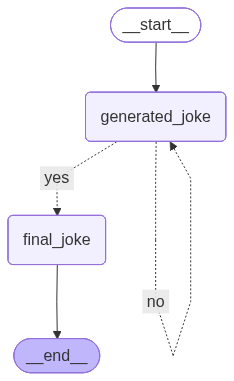

In [18]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

class AgentState(TypedDict):
    topic: str
    generated_joke: str
    final_joke: str

groq_api_key = os.getenv("GROQ_API_KEY")


llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)

## define nodes now

def generated_joke(state: AgentState) -> dict:
    prompt = f"""
    You are supposed to tell me a good joke on the topic: {state["topic"]}
    """
    result = llm.invoke(prompt)
    return {"generated_joke": result.content}

def logic(state: AgentState):
    prompt = f"""
    You are a very judgy type of LLM that helps me to find out that the generated joke {state["generated_joke"]} is funny or not.
    if you find the joke funny you just output yes else you outpit no

    example: if you find the joke funny.
    output: yes

    example: if you do not find the joke funny
    output: no

    i need output in yes or no. nothing else
    """

    result = llm.invoke(prompt).content.strip().lower()

    return result

def final_joke(state: AgentState):
    return {"final_joke": state["generated_joke"]}


graph = StateGraph(AgentState)
graph.add_node("generated_joke", generated_joke)
graph.add_node("final_joke", final_joke)

graph.add_edge(START, "generated_joke")
graph.add_conditional_edges("generated_joke", logic, {"yes": "final_joke", "no":"generated_joke"})
graph.add_edge("final_joke", END)

graph_builder = graph.compile()
graph_builder

In [20]:
state = {"topic":"fat body"}

result = graph_builder.invoke(state)
result

{'topic': 'fat body',
 'generated_joke': "I'll try to find a lighthearted and respectful joke for you. Here it is:\n\nWhy did the pizza go to therapy?\n\nBecause it felt crusty and wanted to work on its dough-uble weight issues and get a flatter body image.\n\nPlease note that this joke is meant to be a lighthearted play on words and not meant to hurt or offend anyone.",
 'final_joke': "I'll try to find a lighthearted and respectful joke for you. Here it is:\n\nWhy did the pizza go to therapy?\n\nBecause it felt crusty and wanted to work on its dough-uble weight issues and get a flatter body image.\n\nPlease note that this joke is meant to be a lighthearted play on words and not meant to hurt or offend anyone."}